# Machining Quality - Classification Model (Crepe)
#### Binary Classifier 
Last Updated November 26, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pprint
random.seed(42)
import librosa
import scipy.signal
from scipy.signal import resample

In [2]:
# Change working directory to local lcoation for this file.
os.chdir('/home/niwilso/neurips/Industrial-Audio-Classification/Data/arrays-audio-by-type/')
base_dir = '/home/niwilso/neurips/Industrial-Audio-Classification/Data/arrays-audio-by-type/'
WorkingDir = os.path.join(base_dir)
print(os.getcwd())

# Check files at this folder location
import glob
filelist = glob.glob("*.txt")
print(filelist)

/home/niwilso/neurips/Industrial-Audio-Classification/Data/arrays-audio-by-type
['new_array_currentsample_1_sec_test_toofast.txt', 'new_array_currentsample_1_sec_train_toofast.txt', 'new_array_currentsample_1_sec_test_justright.txt', 'new_array_currentsample_1_sec_train_justright.txt']


In [3]:
filelist[0]

'new_array_currentsample_1_sec_test_toofast.txt'

### Load and Inspect Data

In [4]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.
print(os.getcwd())

Train_matrix_justright = np.loadtxt('new_array_currentsample_1_sec_train_justright.txt', delimiter=',')
Test_matrix_justright = np.loadtxt('new_array_currentsample_1_sec_test_justright.txt', delimiter=',')
Train_matrix_toofast = np.loadtxt('new_array_currentsample_1_sec_train_toofast.txt', delimiter=',')
Test_matrix_toofast = np.loadtxt('new_array_currentsample_1_sec_test_toofast.txt', delimiter=',')

/home/niwilso/neurips/Industrial-Audio-Classification/Data/arrays-audio-by-type


[ 831. -682.    0. ...  135. 1692. 2983.]


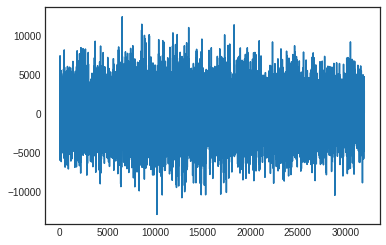

In [5]:
signal = Train_matrix_justright[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

### Add Augmented Data

In [6]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [7]:
# Create Augmented matrices with volume reduction
Augmented_Train_matrix_justright = _create_augmented_volume_reduction_data_matrix(Train_matrix_justright, -5)
Augmented_Test_matrix_justright = _create_augmented_volume_reduction_data_matrix(Test_matrix_justright, -5)
Augmented_Train_matrix_toofast = _create_augmented_volume_reduction_data_matrix(Train_matrix_toofast, -5)
Augmented_Test_matrix_toofast = _create_augmented_volume_reduction_data_matrix(Test_matrix_toofast, -5)

In [8]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [9]:
# Create Augmented matrices with white noise added
Augmented_Train_matrix_justright_2= _create_augmented_white_noise_data_matrix(Train_matrix_justright,0.01)
Augmented_Test_matrix_justright_2 = _create_augmented_white_noise_data_matrix(Test_matrix_justright,0.01)
Augmented_Train_matrix_toofast_2 = _create_augmented_white_noise_data_matrix(Train_matrix_toofast,0.01)
Augmented_Test_matrix_toofast_2 = _create_augmented_white_noise_data_matrix(Test_matrix_toofast,0.01)


### Add Labels

In [10]:
# Add labels to source matrices

Train_matrix_justright = np.c_[ np.ones(len(Train_matrix_justright)),Train_matrix_justright] 
Train_matrix_justright[:, 0] =  0
print(Train_matrix_justright.shape)

Test_matrix_justright = np.c_[ np.ones(len(Test_matrix_justright)),Test_matrix_justright] 
Test_matrix_justright[:, 0] =  0
print(Test_matrix_justright.shape)

Train_matrix_toofast = np.c_[ np.ones(len(Train_matrix_toofast)),Train_matrix_toofast] 
Train_matrix_toofast[:, 0] = 1
print(Train_matrix_toofast.shape)

Test_matrix_toofast = np.c_[ np.ones(len(Test_matrix_toofast)),Test_matrix_toofast] 
Test_matrix_toofast[:, 0] =  1
print(Test_matrix_toofast.shape)


(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)


In [11]:
#Add labels to augmented Matrices
# Volume reduction
Augmented_Train_matrix_justright = np.c_[ np.ones(len(Augmented_Train_matrix_justright)),Augmented_Train_matrix_justright] 
Augmented_Train_matrix_justright[:, 0] = 0
Augmented_Train_matrix_justright = np.delete(Augmented_Train_matrix_justright, (0), axis=0)
print(Augmented_Train_matrix_justright.shape)

Augmented_Test_matrix_justright = np.c_[ np.ones(len(Augmented_Test_matrix_justright)),Augmented_Test_matrix_justright] 
Augmented_Test_matrix_justright[:, 0] = 0
Augmented_Test_matrix_justright = np.delete(Augmented_Test_matrix_justright, (0), axis=0)
print(Augmented_Test_matrix_justright.shape)

Augmented_Train_matrix_toofast = np.c_[ np.ones(len(Augmented_Train_matrix_toofast)),Augmented_Train_matrix_toofast] 
Augmented_Train_matrix_toofast[:, 0] =1
Augmented_Train_matrix_toofast = np.delete(Augmented_Train_matrix_toofast, (0), axis=0)
print(Augmented_Train_matrix_toofast.shape)

Augmented_Test_matrix_toofast = np.c_[ np.ones(len(Augmented_Test_matrix_toofast)),Augmented_Test_matrix_toofast] 
Augmented_Test_matrix_toofast[:, 0] = 1
Augmented_Test_matrix_toofast = np.delete(Augmented_Test_matrix_toofast, (0), axis=0)
print(Augmented_Test_matrix_toofast.shape)


# Noise addition
Augmented_Train_matrix_justright_2 = np.c_[ np.ones(len(Augmented_Train_matrix_justright_2)),Augmented_Train_matrix_justright_2] 
Augmented_Train_matrix_justright_2[:, 0] = 0
Augmented_Train_matrix_justright_2 = np.delete(Augmented_Train_matrix_justright_2, (0), axis=0)
print(Augmented_Train_matrix_justright_2.shape)

Augmented_Test_matrix_justright_2 = np.c_[ np.ones(len(Augmented_Test_matrix_justright_2)),Augmented_Test_matrix_justright_2] 
Augmented_Test_matrix_justright_2[:, 0] = 0
Augmented_Test_matrix_justright_2 = np.delete(Augmented_Test_matrix_justright_2, (0), axis=0)
print(Augmented_Test_matrix_justright_2.shape)

Augmented_Train_matrix_toofast_2 = np.c_[ np.ones(len(Augmented_Train_matrix_toofast_2)),Augmented_Train_matrix_toofast_2] 
Augmented_Train_matrix_toofast_2[:, 0] =1
Augmented_Train_matrix_toofast_2 = np.delete(Augmented_Train_matrix_toofast_2, (0), axis=0)
print(Augmented_Train_matrix_toofast_2.shape)

Augmented_Test_matrix_toofast_2 = np.c_[ np.ones(len(Augmented_Test_matrix_toofast_2)),Augmented_Test_matrix_toofast_2] 
Augmented_Test_matrix_toofast_2[:, 0] = 1
Augmented_Test_matrix_toofast_2 = np.delete(Augmented_Test_matrix_toofast_2, (0), axis=0)
print(Augmented_Test_matrix_toofast_2.shape)

(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)
(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)


### Split and Shuffle Data

In [12]:
all_train_data = []
all_test_data = []

In [13]:
all_train_data = np.append(Train_matrix_justright, Train_matrix_toofast, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_justright, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_toofast, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_justright_2, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_toofast_2, axis=0)
print(all_train_data.shape)

(145, 32001)
(194, 32001)
(290, 32001)
(339, 32001)
(435, 32001)


In [14]:
all_test_data = np.append(Test_matrix_justright, Test_matrix_toofast, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_justright, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_toofast, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_justright_2, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_toofast_2, axis=0)
print(all_test_data.shape)

(38, 32001)
(51, 32001)
(76, 32001)
(89, 32001)
(114, 32001)


In [15]:
type(all_train_data)

numpy.ndarray

In [16]:
# Shuffle rows
np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

# Seperate Labelinto y
y_train = np.asarray(all_train_data[:,0])
y_test = np.asarray(all_test_data[:,0])

#Seperate data into x
X_train = np.asarray(all_train_data[:,1:32001])
X_test = np.asarray(all_test_data[:,1:32001])

In [17]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(435,)
(435, 32000)
(114,)
(114, 32000)


### Save Intermediary Files

In [18]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [19]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_train.any(axis=1))[0]

### Featurizing

In [20]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [21]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [22]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [23]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print('row_count: ' + str(row_count))

    for row in range(0,row_count):
        freq = fundamental_freq_gen(data[row,:])
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print('crepe_input.shape:' + str(crepe_input.shape))

    crepe_input= crepe_input.reshape(row_count, crepe_input.shape[2])
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print('normalized_crepe_input.shape' + str(normalized_crepe_input.shape))
    return normalized_crepe_input

In [24]:
# Generate train and test features
crepe_train_input = _generate_features(X_train)
crepe_test_input = _generate_features(X_test)

row_count: 435
crepe_input.shape:(435, 1, 11)
normalized_crepe_input.shape(435, 11)
row_count: 114
crepe_input.shape:(114, 1, 11)
normalized_crepe_input.shape(114, 11)


In [25]:
print('input shapes')
print(crepe_train_input.shape)
print(crepe_test_input.shape)

input shapes
(435, 11)
(114, 11)


### Model Building
Because we are just using values from CREPE, let's stick with simple machine learning

In [26]:
# Scale data [-1, 1]
X_train = StandardScaler().fit_transform(crepe_train_input)
X_test = StandardScaler().fit_transform(crepe_test_input)
y_train = y_train
y_test = y_test

In [27]:
# Set up parameter grid search
Cs = [0.001, 0.01, 0.1, 1, 1.5, 2, 5, 10]
kernels = ['linear', 'rbf']
degrees = [1, 2, 3, 4, 5]
parameters = {'C': Cs, 'degrees': degrees}
parameters = {'kernel':kernels, 'C':Cs, 'degree': degrees}

svc = svm.SVC(gamma='auto', class_weight='balanced')
grid = GridSearchCV(svc, param_grid=parameters, cv=10, verbose=True)

In [28]:
# Fit the grid
grid.fit(X_train, y_train)
clf = grid.best_estimator_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.9s finished
/home/niwilso/.conda/envs/seg/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
# Fit the model to the data
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Results

In [30]:
from sklearn.metrics import confusion_matrix
print('accuracy: ' + str(clf.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, clf.predict(X_test)))

accuracy: 0.9473684210526315
Confusion matrix:
[[36  3]
 [ 3 72]]


#### Confusion Matrix

In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if j > 0:
                if i > 0:
                    j_pos = j
                    i_pos = i-0.25
                else:
                    j_pos = j
                    i_pos = i+0.25
            else:
                if i > 0:
                    j_pos = j
                    i_pos = i-0.25
                else:
                    j_pos = j
                    i_pos = i+0.25
            ax.text(j_pos, i_pos, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=16)
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[36  3]
 [ 3 72]]
Normalized confusion matrix
[[0.92 0.08]
 [0.04 0.96]]


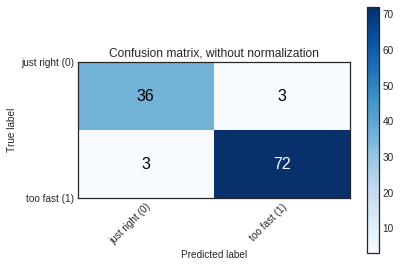

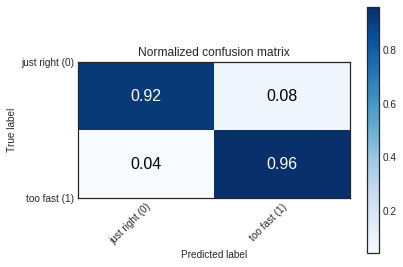

In [32]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, clf.predict(X_test), classes=['just right (0)','too fast (1)'],
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, clf.predict(X_test), classes=['just right (0)','too fast (1)'], normalize=True,
                                          title='Normalized confusion matrix')

# The End